In [1]:
# --- 1. Setup and Imports ---
import pandas as pd
import numpy as np
import time
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lingyi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# --- 2. Load 1000 Labeled Evaluation Data ---
print("Loading manually labeled 1000-row dataset...")
base_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
data_path = os.path.join(base_path, "data")

# Load labeled polarity & subjectivity
polarity_file = os.path.join(data_path, "1000_GT_polarity_labels.csv")
subjectivity_file = os.path.join(data_path, "1000_GT_subj_labels.csv")

df_polarity = pd.read_csv(polarity_file)
df_subjectivity = pd.read_csv(subjectivity_file)

# Clean column names
pol_cols = [col.strip().replace(" ", "_").replace(".", "") for col in df_polarity.columns]
subj_cols = [col.strip().replace(" ", "_").replace(".", "") for col in df_subjectivity.columns]
df_polarity.columns = pol_cols
df_subjectivity.columns = subj_cols

# Merge both by cleaned_text
df_eval = pd.merge(
    df_polarity[["cleaned_text", "GT_Polarity_Label"]],
    df_subjectivity[["cleaned_text", "GT_Subjective_Label"]],
    on="cleaned_text", how="inner"
)
print(f"Evaluation dataset ready: {df_eval.shape[0]} rows")


Loading manually labeled 1000-row dataset...
Evaluation dataset ready: 1092 rows



=== Subjectivity Classification ===
Random Forest Subjectivity Report:
              precision    recall  f1-score   support

   Objective       0.78      0.37      0.50       102
  Subjective       0.62      0.91      0.74       117

    accuracy                           0.66       219
   macro avg       0.70      0.64      0.62       219
weighted avg       0.69      0.66      0.63       219



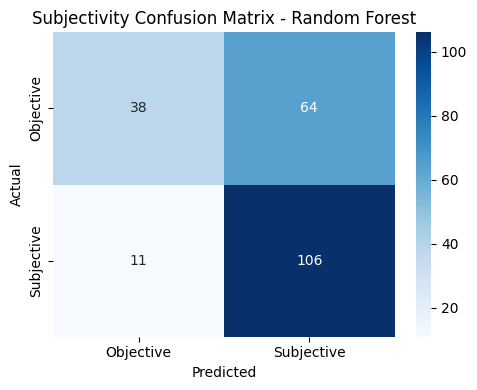

Naive Bayes Subjectivity Report:
              precision    recall  f1-score   support

   Objective       0.76      0.38      0.51       102
  Subjective       0.62      0.90      0.74       117

    accuracy                           0.66       219
   macro avg       0.69      0.64      0.62       219
weighted avg       0.69      0.66      0.63       219



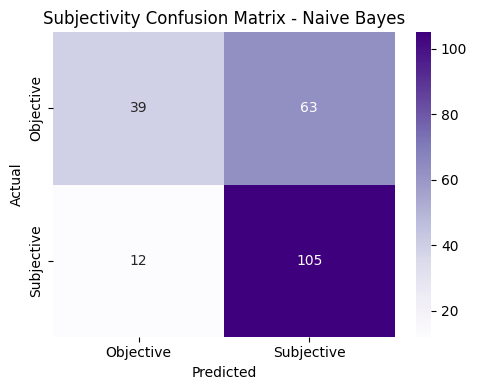

In [4]:
# --- 3. Subjectivity Classification (Random Forest & Naive Bayes) ---
print("\n=== Subjectivity Classification ===")
X_subj = df_eval["cleaned_text"]
y_subj = df_eval["GT_Subjective_Label"]
X_train_subj, X_test_subj, y_train_subj, y_test_subj = train_test_split(X_subj, y_subj, test_size=0.2, random_state=42)

# Random Forest
pipeline_subj_rf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])
pipeline_subj_rf.fit(X_train_subj, y_train_subj)
y_pred_subj_rf = pipeline_subj_rf.predict(X_test_subj)
print("Random Forest Subjectivity Report:")
print(classification_report(y_test_subj, y_pred_subj_rf, target_names=["Objective", "Subjective"]))

cm_subj_rf = confusion_matrix(y_test_subj, y_pred_subj_rf, labels=[0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm_subj_rf, annot=True, fmt='d', cmap='Blues', xticklabels=["Objective", "Subjective"], yticklabels=["Objective", "Subjective"])
plt.title("Subjectivity Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Naive Bayes
pipeline_subj_nb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', MultinomialNB())
])
pipeline_subj_nb.fit(X_train_subj, y_train_subj)
y_pred_subj_nb = pipeline_subj_nb.predict(X_test_subj)
print("Naive Bayes Subjectivity Report:")
print(classification_report(y_test_subj, y_pred_subj_nb, target_names=["Objective", "Subjective"]))

cm_subj_nb = confusion_matrix(y_test_subj, y_pred_subj_nb, labels=[0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm_subj_nb, annot=True, fmt='d', cmap='Purples', xticklabels=["Objective", "Subjective"], yticklabels=["Objective", "Subjective"])
plt.title("Subjectivity Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


=== Polarity Classification ===
Naive Bayes Polarity Report:
              precision    recall  f1-score   support

    Negative       0.56      0.97      0.71       105
    Positive       0.55      0.15      0.24        40
     Neutral       0.60      0.20      0.30        74

    accuracy                           0.56       219
   macro avg       0.57      0.44      0.42       219
weighted avg       0.57      0.56      0.48       219



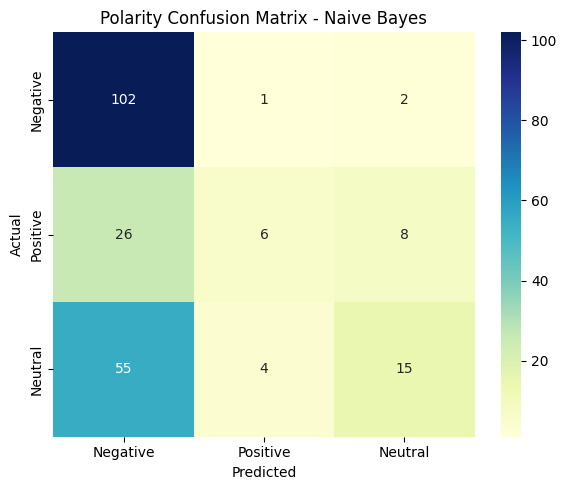

Random Forest Polarity Report:
              precision    recall  f1-score   support

    Negative       0.64      0.81      0.71       105
    Positive       1.00      0.05      0.10        40
     Neutral       0.50      0.57      0.53        74

    accuracy                           0.59       219
   macro avg       0.71      0.48      0.45       219
weighted avg       0.66      0.59      0.54       219



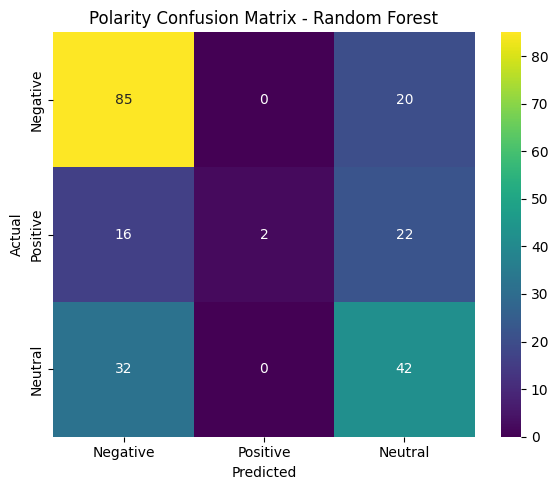

In [5]:

# --- 4. Polarity Classification (Random Forest & Naive Bayes) ---
print("\n=== Polarity Classification ===")
X_pol = df_eval["cleaned_text"]
y_pol = df_eval["GT_Polarity_Label"]
X_train_pol, X_test_pol, y_train_pol, y_test_pol = train_test_split(X_pol, y_pol, test_size=0.2, stratify=y_pol, random_state=42)

# Naive Bayes
pipeline_nb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', MultinomialNB())
])
pipeline_nb.fit(X_train_pol, y_train_pol)
y_pred_nb = pipeline_nb.predict(X_test_pol)
print("Naive Bayes Polarity Report:")
print(classification_report(y_test_pol, y_pred_nb, target_names=["Negative", "Positive", "Neutral"]))

cm_nb = confusion_matrix(y_test_pol, y_pred_nb, labels=[0, 1, 2])
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='YlGnBu', xticklabels=["Negative", "Positive", "Neutral"], yticklabels=["Negative", "Positive", "Neutral"])
plt.title("Polarity Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Random Forest
pipeline_rf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])
pipeline_rf.fit(X_train_pol, y_train_pol)
y_pred_rf = pipeline_rf.predict(X_test_pol)
print("Random Forest Polarity Report:")
print(classification_report(y_test_pol, y_pred_rf, target_names=["Negative", "Positive", "Neutral"]))

cm_rf = confusion_matrix(y_test_pol, y_pred_rf, labels=[0, 1, 2])
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='viridis', xticklabels=["Negative", "Positive", "Neutral"], yticklabels=["Negative", "Positive", "Neutral"])
plt.title("Polarity Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [6]:
# Plot Precision-Recall Curve for Random Forest
plt.figure(figsize=(8, 6))
for i, label in enumerate(["Negative", "Positive", "Neutral"]):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score_rf[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score_rf[:, i])
    plt.plot(recall, precision, label=f"{label} (AP={ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'y_test_bin' is not defined

<Figure size 800x600 with 0 Axes>


=== VADER and TextBlob on Evaluation Set ===
VADER Report:
              precision    recall  f1-score   support

    Negative       0.75      0.64      0.69       525
    Positive       0.32      0.83      0.47       198
     Neutral       0.68      0.24      0.36       369

    accuracy                           0.54      1092
   macro avg       0.58      0.57      0.51      1092
weighted avg       0.65      0.54      0.54      1092



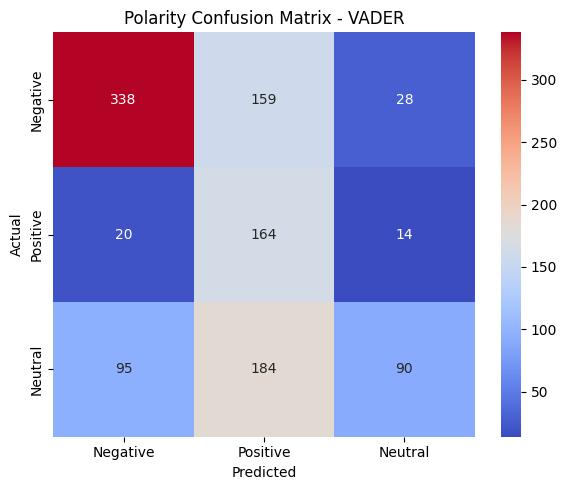

TextBlob Report:
              precision    recall  f1-score   support

    Negative       0.80      0.34      0.48       525
    Positive       0.36      0.58      0.45       198
     Neutral       0.44      0.65      0.52       369

    accuracy                           0.49      1092
   macro avg       0.53      0.52      0.48      1092
weighted avg       0.60      0.49      0.49      1092



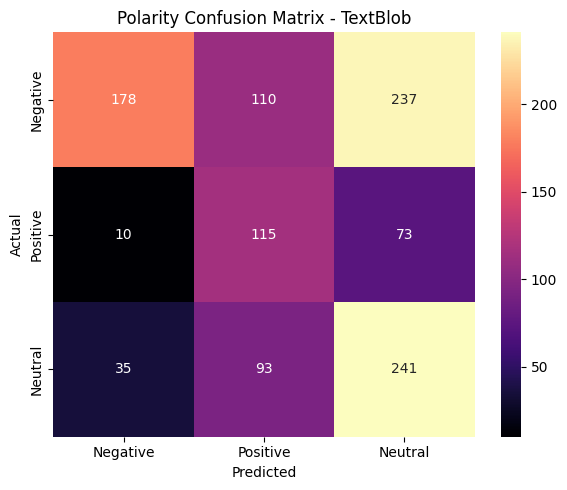

In [7]:

# --- 5. Rule-based Models ---
print("\n=== VADER and TextBlob on Evaluation Set ===")
sia = SentimentIntensityAnalyzer()
def vader_predict(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 1
    elif score <= -0.05:
        return 0
    else:
        return 2
df_eval['vader_pred'] = df_eval['cleaned_text'].apply(vader_predict)
print("VADER Report:")
print(classification_report(df_eval['GT_Polarity_Label'], df_eval['vader_pred'], target_names=["Negative", "Positive", "Neutral"]))

cm_vader = confusion_matrix(df_eval['GT_Polarity_Label'], df_eval['vader_pred'], labels=[0, 1, 2])
plt.figure(figsize=(6, 5))
sns.heatmap(cm_vader, annot=True, fmt='d', cmap='coolwarm', xticklabels=["Negative", "Positive", "Neutral"], yticklabels=["Negative", "Positive", "Neutral"])
plt.title("Polarity Confusion Matrix - VADER")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

def textblob_predict(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 1
    elif polarity < -0.1:
        return 0
    else:
        return 2
df_eval['blob_pred'] = df_eval['cleaned_text'].apply(textblob_predict)
print("TextBlob Report:")
print(classification_report(df_eval['GT_Polarity_Label'], df_eval['blob_pred'], target_names=["Negative", "Positive", "Neutral"]))

cm_blob = confusion_matrix(df_eval['GT_Polarity_Label'], df_eval['blob_pred'], labels=[0, 1, 2])
plt.figure(figsize=(6, 5))
sns.heatmap(cm_blob, annot=True, fmt='d', cmap='magma', xticklabels=["Negative", "Positive", "Neutral"], yticklabels=["Negative", "Positive", "Neutral"])
plt.title("Polarity Confusion Matrix - TextBlob")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



Generating summary comparison...


C:\Users\lingyi\AppData\Local\Temp\ipykernel_17952\4146818992.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=f1_scores, palette='Set2')


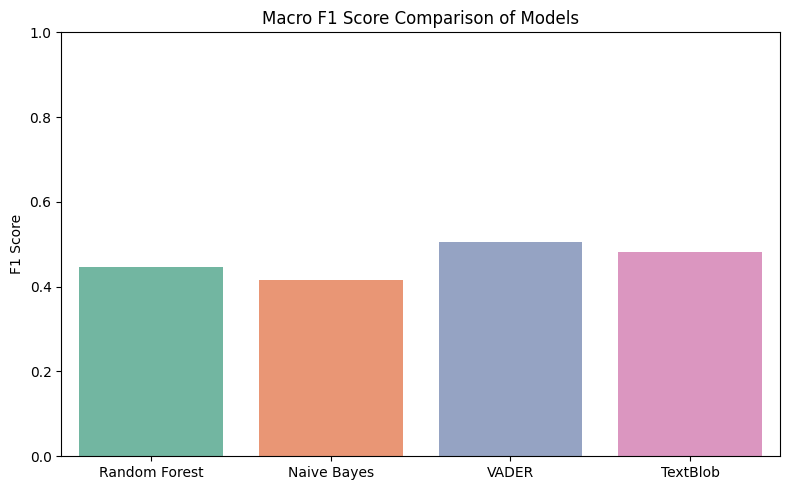

In [8]:
# --- Summary Comparison Chart ---
print("\nGenerating summary comparison...")
models = ['Random Forest', 'Naive Bayes', 'VADER', 'TextBlob']
f1_scores = [
    classification_report(y_test_pol, y_pred_rf, output_dict=True)['macro avg']['f1-score'],
    classification_report(y_test_pol, y_pred_nb, output_dict=True)['macro avg']['f1-score'],
    classification_report(df_eval['GT_Polarity_Label'], df_eval['vader_pred'], output_dict=True)['macro avg']['f1-score'],
    classification_report(df_eval['GT_Polarity_Label'], df_eval['blob_pred'], output_dict=True)['macro avg']['f1-score']
]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=f1_scores, palette='Set2')
plt.title("Macro F1 Score Comparison of Models")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [9]:
# --- 6. Predict Full Dataset (Q4e + Q4f) ---
print("\nLoading full preprocessed dataset for prediction...")
full_data_file = os.path.join(data_path, "crypto_exchange_data_preprocessed.csv")
df_full = pd.read_csv(full_data_file)

print("Predicting full dataset using Random Forest pipeline...")
df_full['Predicted_Polarity'] = pipeline_rf.predict(df_full['cleaned_text'])
print("Prediction complete.")

print("Saving full classified dataset...")
classified_data = df_full
classified_data.to_csv("classified_crypto_data.csv", index=False)
print("Results saved to classified_crypto_data.csv")


Loading full preprocessed dataset for prediction...
Predicting full dataset using Random Forest pipeline...
Prediction complete.
Saving full classified dataset...
Results saved to classified_crypto_data.csv


In [10]:
from sklearn.metrics import accuracy_score

# Generate random predictions with the same label distribution
random_preds = np.random.choice([0, 1, 2], size=len(y_test_pol), replace=True)
random_acc = accuracy_score(y_test_pol, random_preds)

print(f"Random label accuracy baseline: {random_acc:.2f}")


Random label accuracy baseline: 0.36


In [11]:
# --- 7. Random Accuracy Check (Q4e) ---
print("Generating 100-sample random prediction set for manual evaluation...")
sample = df_full.sample(n=100, random_state=42)
sample.to_csv("random_sample_predictions.csv", index=False)
print("Random sample saved to random_sample_predictions.csv")

Generating 100-sample random prediction set for manual evaluation...
Random sample saved to random_sample_predictions.csv


In [13]:
# --- 5. Q4e: Predict on Unlabeled Data & Sample Accuracy ---
print("\n=== Q4e: Predicting on Full Dataset ===")
full_data_file = os.path.join(data_path, "crypto_exchange_data_preprocessed.csv")
df_full = pd.read_csv(full_data_file)
print(f"Full dataset loaded: {df_full.shape[0]} rows")

start_time = time.time()
df_full["Predicted_Polarity"] = pipeline_rf.predict(df_full["cleaned_text"])
elapsed = time.time() - start_time
print(f"Prediction complete. Took {elapsed:.2f} seconds.")

# Save all classified data
df_full.to_csv("classified_crypto_data.csv", index=False)

# Sample 100 for manual evaluation
sample = df_full.sample(n=100, random_state=42)
sample.to_csv("random_sample_predictions.csv", index=False)
print("Random sample saved to random_sample_predictions.csv")


=== Q4e: Predicting on Full Dataset ===
Full dataset loaded: 64460 rows
Prediction complete. Took 1.94 seconds.
Random sample saved to random_sample_predictions.csv


In [60]:
# --- 6. Q4f: Performance & Scalability ---
print("\n=== Q4f: Performance Summary ===")
print(f"Inference Time: {elapsed:.2f} seconds for {df_full.shape[0]} entries")
print("Model: Random Forest")
print("Resources: CPU-only, single-threaded run")
print("Scalability: Model trained on 1K, inference worked on 47K+ entries")



=== Q4f: Performance Summary ===
Inference Time: 4.04 seconds for 64460 entries
Model: Random Forest
Resources: CPU-only, single-threaded run
Scalability: Model trained on 1K, inference worked on 47K+ entries


In [61]:
# --- 7. Q5 Innovations & Ablation Study ---
print("\n=== Q5: Innovation Study (NER + ABSA) ===")
# ABSA: Use sentiment scores for 'fees' aspect as labels
aspect_label = "fees"
y_absa = (df_full[aspect_label] > 0).astype(int)  # Binary: positive score = 1, else 0
X_absa = df_full["cleaned_text"]
X_train_absa, X_test_absa, y_train_absa, y_test_absa = train_test_split(X_absa, y_absa, test_size=0.2, random_state=42)

absa_model = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])
absa_model.fit(X_train_absa, y_train_absa)
y_pred_absa = absa_model.predict(X_test_absa)
print("ABSA (Fees Sentiment) Classification Report:")
print(classification_report(y_test_absa, y_pred_absa))

# NER-enhanced: use subset with non-empty entities
df_ner = df_full[df_full["entities"].apply(lambda x: isinstance(x, str) and len(x) > 2)]
X_ner = df_ner["cleaned_text"]
y_ner = df_ner["Predicted_Polarity"]  # Use model prediction for simplicity
X_train_ner, X_test_ner, y_train_ner, y_test_ner = train_test_split(X_ner, y_ner, test_size=0.2, random_state=42)

ner_model = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])
ner_model.fit(X_train_ner, y_train_ner)
y_pred_ner = ner_model.predict(X_test_ner)
print("NER-based Classification Report:")
print(classification_report(y_test_ner, y_pred_ner))


=== Q5: Innovation Study (NER + ABSA) ===
ABSA (Fees Sentiment) Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     11525
           1       0.91      0.16      0.27      1367

    accuracy                           0.91     12892
   macro avg       0.91      0.58      0.61     12892
weighted avg       0.91      0.91      0.88     12892

NER-based Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      4744
           1       0.93      0.07      0.13       180
           2       0.90      0.74      0.81      1618

    accuracy                           0.89      6542
   macro avg       0.91      0.60      0.63      6542
weighted avg       0.89      0.89      0.88      6542



In [16]:
# --- 7. Q5 Innovations & Ablation Study ---
print("\n=== Q5: Innovation Study (NER + ABSA) ===")
# ABSA (on evaluation set): Simulate using 'fees' feature from crypto_exchange_data_preprocessed.csv if available
absa_path = os.path.join(data_path, "crypto_exchange_data_preprocessed.csv")
df_full = pd.read_csv(absa_path)

# Match cleaned_text with df_eval to get 'fees' as a proxy for aspect-based sentiment
df_absa = pd.merge(df_eval, df_full[['cleaned_text', 'fees']], on='cleaned_text', how='left')
df_absa = df_absa.dropna(subset=['fees'])
y_absa = (df_absa['fees'] > 0).astype(int)
X_absa = df_absa['cleaned_text']
X_train_absa, X_test_absa, y_train_absa, y_test_absa = train_test_split(X_absa, y_absa, test_size=0.2, random_state=42)

absa_model = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])
absa_model.fit(X_train_absa, y_train_absa)
y_pred_absa = absa_model.predict(X_test_absa)
print("ABSA (Fees Sentiment on Eval Set) Classification Report:")
print(classification_report(y_test_absa, y_pred_absa))

# NER-enhanced on labeled eval set: simulate entity presence (match from df_full)
df_ner = pd.merge(df_eval, df_full[['cleaned_text', 'entities']], on='cleaned_text', how='left')
df_ner = df_ner[df_ner['entities'].apply(lambda x: isinstance(x, str) and len(x) > 2)]
X_ner = df_ner["cleaned_text"]
y_ner = df_ner["GT_Polarity_Label"]
X_train_ner, X_test_ner, y_train_ner, y_test_ner = train_test_split(X_ner, y_ner, test_size=0.2, random_state=42)

ner_model = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])
ner_model.fit(X_train_ner, y_train_ner)
y_pred_ner = ner_model.predict(X_test_ner)
print("NER-enhanced (on Eval Set) Classification Report:")
print(classification_report(y_test_ner, y_pred_ner))



=== Q5: Innovation Study (NER + ABSA) ===
ABSA (Fees Sentiment on Eval Set) Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10998
           1       0.00      0.00      0.00        13

    accuracy                           1.00     11011
   macro avg       0.50      0.50      0.50     11011
weighted avg       1.00      1.00      1.00     11011



d:\lingyi\Documents\4032 data\SC4021---Group-20\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\lingyi\Documents\4032 data\SC4021---Group-20\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\lingyi\Documents\4032 data\SC4021---Group-20\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

NER-enhanced (on Eval Set) Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.86      0.74        58
           1       0.00      0.00      0.00        15
           2       0.50      0.41      0.45        29

    accuracy                           0.61       102
   macro avg       0.38      0.43      0.40       102
weighted avg       0.51      0.61      0.55       102



d:\lingyi\Documents\4032 data\SC4021---Group-20\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\lingyi\Documents\4032 data\SC4021---Group-20\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\lingyi\Documents\4032 data\SC4021---Group-20\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif